In [1]:
# get rid of the annoying ipython import cache
%load_ext autoreload
%autoreload 2

In [2]:
# Python
from __future__ import annotations
# External
from scipy.stats import uniform, randint
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn import model_selection as sklms
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

## Load data and Pipeline
Reset pipeline fitting just in case (the pipeline is stored prefitted on the whole
dataset, ready for production server).

In [3]:
data = pd.read_pickle('core/loading/listings.pkl.gzip')
pipeline = joblib.load('core/preprocessing/pipeline.joblib')
pipeline.fit(data.iloc[:1])  # Reset prefitting

ColumnTransformer(n_jobs=-1,
                  transformers=[('cheques',
                                 PipelineWithNames(steps=[('impute',
                                                           SimpleImputerWithNames(fill_value=0,
                                                                                  strategy='constant')),
                                                          ('untouched',
                                                           UntouchedTransformer())]),
                                 ['cheques']),
                                ('timing',
                                 TimingTransformer(end='valid_to',
                                                   start='valid_from'),
                                 ['valid_from', 'valid_to']),
                                ('offer_type', OneHotEncoder(sparse=False),
                                 ['offer_type']),
                                ('be...
                                 BathBedRa

## Train-Test split
This might look very dangerous (the target variable 'price') is included into the
input space. However, it will be eliminated by the Pipeline.
It's gonna be used only in the computation of PricePerSqFtPerArea (without data leak).
See research.core.preprocessing.custom.H3PricePerAreaTransformer code for more information.

In [4]:
columns_Y = ['price']
columns_X = [column for column in data.columns]
X, Y = data[columns_X], data[columns_Y]
X_train, X_test, Y_train, Y_test = sklms.train_test_split(X, Y, test_size=0.1,
                                                          shuffle=True, stratify=None)

In [5]:
def metrics(costs):
    costs = np.array(costs)
    return costs.mean().round(), costs.std().round()

In [6]:
model = DummyRegressor(strategy='mean')
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


(-2189418.0, 71033.0)

In [7]:
model = Pipeline([
    ('transform', pipeline),
    ('scale', StandardScaler()),
    ('predict', LinearRegression())
])
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.1s finished


(-1868218.0, 32801.0)

In [8]:
model = Pipeline([
    ('transform', pipeline),
    ('scale', StandardScaler()),
    ('predict', KNeighborsRegressor(n_neighbors=50))
])
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


(-728817.0, 43011.0)

In [9]:
model = Pipeline([
    ('transform', pipeline),
    ('scale', StandardScaler()),
    ('predict', GradientBoostingRegressor())
])
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


(-736987.0, 34522.0)

In [10]:
model = Pipeline([
    ('transform', pipeline),
    ('predict', RandomForestRegressor(n_estimators=100))
])
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


(-478695.0, 51852.0)

In [11]:
model = Pipeline([
    ('transform', pipeline),
    ('predict', XGBRegressor())
])
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
metrics(scores) #

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.5s finished


(-550092.0, 63550.0)

Usually XGBR gives better results than RFR. Current results require additional time to think.

## Hyper Parameters Search
This step requires more searching time, to give better results.

In [12]:
X_full = pd.DataFrame(pipeline.fit_transform(X), columns=pipeline.get_feature_names())

In [13]:
model = XGBRegressor(objective='reg:squarederror', eval_metric='mae', base_score=Y_train['price'].mean())
params = {
    'n_trees': randint(50,500),
    'eta': uniform(0.002, 0.005),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'learning_rate': uniform(0.03, 0.3),
    'max_depth': randint(2, 6),
    'n_estimators': randint(50, 250),
    'subsample': uniform(0.7, 0.3)
}
search = sklms.RandomizedSearchCV(model, param_distributions=params, n_iter=50,
                                  cv=4, verbose=2, n_jobs=-1, return_train_score=True,
                                  scoring='neg_mean_absolute_error')
search.fit(X_full, Y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[09:04:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { n_trees } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.3min finished


RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=1940359.980962963,
                                          booster=None, colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          eval_metric='mae', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_cons...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f99fb963e50>,
                                        'n_estimators': <scipy.sta

In [15]:
best = search.cv_results_['rank_test_score'].argmin()
score = search.cv_results_['mean_test_score'][best]
search.cv_results_['params'][best]

-609566.3685229167


{'colsample_bytree': 0.9520247931567312,
 'eta': 0.00248350928734976,
 'gamma': 0.05499852955296358,
 'learning_rate': 0.07841752036540924,
 'max_depth': 5,
 'n_estimators': 145,
 'n_trees': 296,
 'subsample': 0.9957199636599781}

## Evaluation

In [6]:
params = {'objective': 'reg:squarederror',
          'eval_metric': 'mae',
          'colsample_bytree': 0.9520247931567312,
          'eta': 0.00248350928734976,
          'gamma': 0.05499852955296358,
          'learning_rate': 0.07841752036540924,
          'max_depth': 5,
          'n_estimators': 145,
          'n_trees': 296,
          'subsample': 0.9957199636599781}
model = XGBRegressor(**params)

In [17]:
model.fit(pipeline.fit_transform(X_train), Y_train)

[09:08:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { n_trees } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9520247931567312,
             eta=0.00248350928734976, eval_metric='mae',
             gamma=0.05499852955296358, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.07841752036540924,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=145, n_jobs=0, n_trees=296,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9957199636599781,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
prediction = model.predict(pipeline.transform(X_test))

In [19]:
errors = np.abs(Y_test.iloc[:,0] - prediction)
print(f'MAE: {errors.mean().round()}')
print(f'Min: {errors.min().round()}')
print(f'Max: {errors.max().round()}')
print(f'50%: {np.quantile(errors, 0.50).round()}')
print(f'75%: {np.quantile(errors, 0.75).round()}')

MAE: 531372.0
Min: 64.0
Max: 379560883.0
50%: 105017.0
75%: 325224.0


Performance of the final model.
In average model's evaluation differs from real price by 531k dirham.
Minimum - 64 dirham, maximum - 379 millions.
However, in 75% of the cases model's error is 325k dirham.

## Final Model

In [7]:
features = pd.DataFrame(pipeline.fit_transform(X), columns=pipeline.get_feature_names())
target = Y
model.fit(features, target)

[10:59:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { n_trees } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9520247931567312,
             eta=0.00248350928734976, eval_metric='mae',
             gamma=0.05499852955296358, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.07841752036540924,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=145, n_jobs=0, n_trees=296,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9957199636599781,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Quick Look Inside the Model

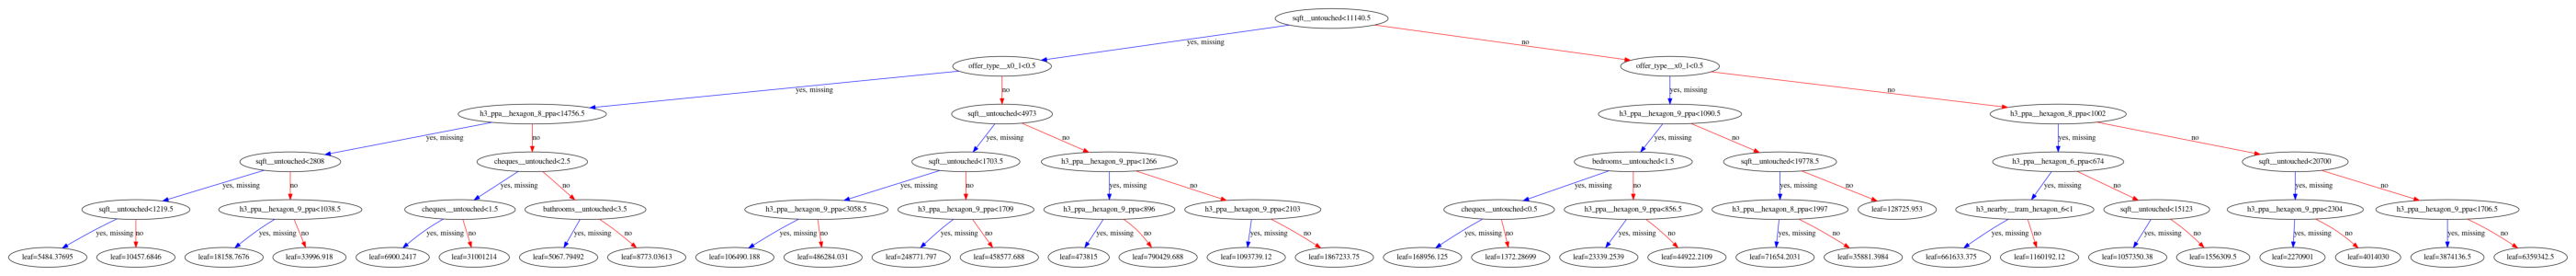

In [39]:
xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

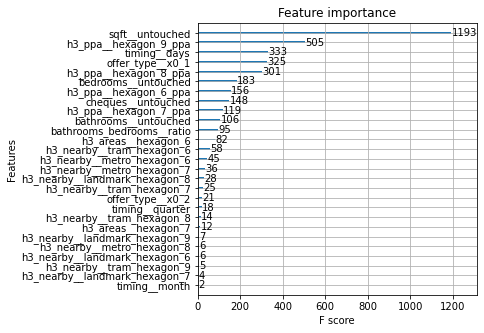

In [37]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Dump

In [7]:
joblib.dump(model, 'core/models/avm.joblib', protocol=4)

['core/models/avm.joblib']

## What could be done better?
Models:
- Stack several models (might be several layers)
- Try out NN's (even the simpliest MLP could show some interesting results)
- Ridge Regression (relation between features and target is probably quasi-linear)
- More feature scaling/transformation
- log(target) to make the price more linear
- try to use price_per_sqft as the target variable